<a href="https://colab.research.google.com/github/trisharaj1/Stroke-Prediction-Model/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle.json'

In [ ]:
! kaggle datasets download -d fedesoriano/stroke-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
stroke-prediction-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import pandas as pd
df = pd.read_csv('/content/stroke-prediction-dataset.zip')
df = df.drop(['id'], axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
categorical_features=['gender','ever_married','work_type','Residence_type','smoking_status']
unique_values = {col:df[col].unique() for col in categorical_features}

In [ ]:
for col, values in unique_values.items():
  print(f"{col}: {values}")

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
df.duplicated().sum()

0

In [ ]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [ ]:
y = df['stroke']
y.value_counts(normalize=True)*100

,proportion
stroke,
0,95.127202
1,4.872798


In [ ]:
import plotly.express as px
px.bar(x=y.value_counts().index, y=y.value_counts(), color=y.value_counts().index)

In [ ]:
numerical_features = ['age','avg_glucose_level','bmi']
df[numerical_features].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>, <Axes: >]], dtype=object)

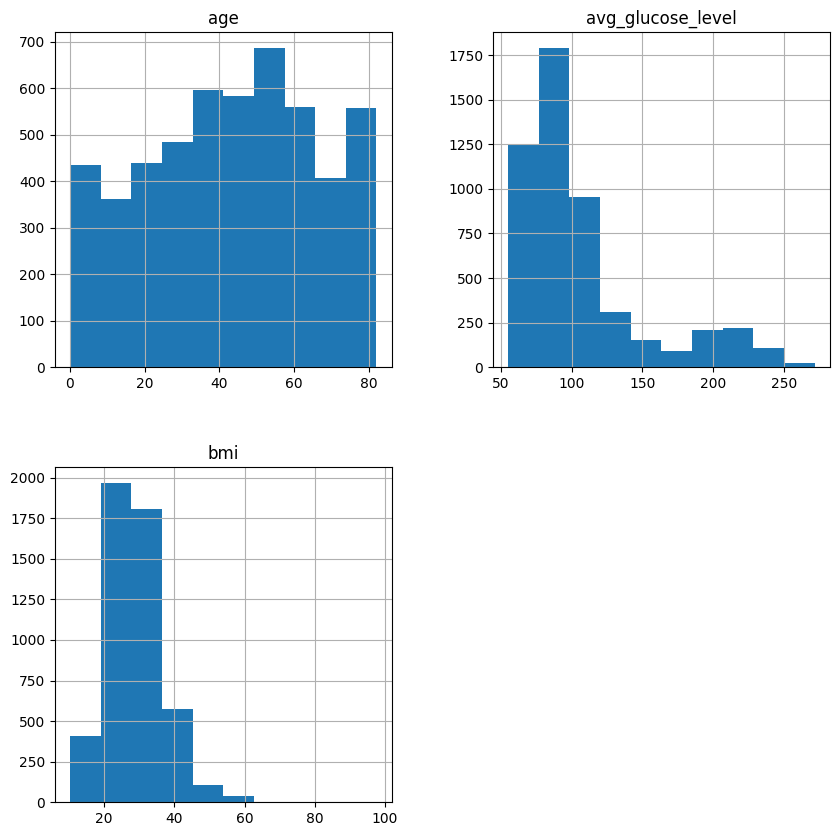

In [ ]:
df[numerical_features].hist(figsize=(10,10))

In [ ]:
fig = px.histogram(df, x='gender', width=400)
fig.show()

In [ ]:
df[df['gender']=='Female']['stroke'].mean()*100

4.709418837675351

1. Weak Positive Relationship (0.25) between age and stroke
2. Slight difference in avg. glucose levels between stroke/no stroke
3. BMI shows no significant relation to stroke
4. Hypertension increases stroke risk by 3.3x
5. Males slightly more likely to have stroke than females
6. Heart disease increases stroke risk 4.07x
7. Married individuals 5.7x more likely to have a stroke
8. Self-employed individuals have higher stroke probability
9. Rural residents are slightly more likely to have a stroke than urban
10. Little difference in stroke risk between smokers and non smokers

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Define the numerical and categorical columns
numerical = ['age', 'avg_glucose_level', 'bmi']
categorical = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Define the transformation pipeline for preprocessing
transformer = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('power', PowerTransformer(method='yeo-johnson', standardize=True))
    ]), numerical),
    ('cat', OneHotEncoder(), categorical)
])

# Define the models
def get_models():
    models, names = list(), list()
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    return models, names

# Define the evaluation function
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

# Extract features and target variable
y = df['stroke']
X = df.drop('stroke', axis=1)

# Get models
models, names = get_models()
results = list()

# Iterate over models and evaluate
for i in range(len(models)):
    # Create the pipeline for each model
    pipeline = IMBPipeline(steps=[
        ('transformer', transformer),
        ('smote', SMOTE()),
        ('model', models[i])
    ])

    # Evaluate the pipeline with cross-validation
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)

    # Print the results
    print('>%s: ROC-AUC = %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


>LR: ROC-AUC = 0.835 (0.029)
>LDA: ROC-AUC = 0.837 (0.030)
>RF: ROC-AUC = 0.778 (0.026)
